In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from google.colab import files
uploaded = files.upload()

Saving pivoted_df.csv to pivoted_df.csv


Load the dataframe in, inspect the data.

In [2]:
pivoted_df = pd.read_csv('pivoted_df.csv', index_col=0)

In [3]:
pivoted_df.head()

,season,Age,Throws,Surgery,AB_release_speed_weighted_avg,CH_release_speed_weighted_avg,CS_release_speed_weighted_avg,CU_release_speed_weighted_avg,EP_release_speed_weighted_avg,FA_release_speed_weighted_avg,...,FS_vz0_weighted_avg,IN_vz0_weighted_avg,KC_vz0_weighted_avg,KN_vz0_weighted_avg,PO_vz0_weighted_avg,SC_vz0_weighted_avg,SI_vz0_weighted_avg,SL_vz0_weighted_avg,ST_vz0_weighted_avg,SV_vz0_weighted_avg
0,2008,37.0,1,0.0,0.0,82.641530,0.0,75.425843,0.0,0.0,...,0.0,7.335296,0.0,0.0,1.676319,0.0,-4.087597,-3.339929,0.0,0.0
1,2009,38.0,1,0.0,0.0,85.012195,0.0,78.181818,0.0,0.0,...,0.0,4.971030,0.0,0.0,0.000000,0.0,-3.124205,-2.492202,0.0,0.0
2,2010,39.0,1,0.0,0.0,84.150000,0.0,74.666667,0.0,0.0,...,0.0,5.705495,0.0,0.0,-0.118320,0.0,-3.576961,-3.186056,0.0,0.0
3,2011,40.0,1,0.0,0.0,83.093750,0.0,76.885714,0.0,0.0,...,0.0,7.108895,0.0,0.0,-0.907724,0.0,-3.631151,-2.303028,0.0,0.0
4,2012,41.0,1,0.0,0.0,83.001563,0.0,76.427273,0.0,0.0,...,0.0,7.101314,0.0,0.0,0.000000,0.0,-4.538380,-2.684632,0.0,0.0


In [4]:
pivoted_df.shape

(3688, 130)

In [5]:
pivoted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3688 entries, 0 to 3687
Columns: 130 entries, season to SV_vz0_weighted_avg
dtypes: float64(128), int64(2)
memory usage: 3.7 MB


In [6]:
pivoted_df['Surgery'].value_counts()

0.0    2772
1.0     916
Name: Surgery, dtype: int64

Time to start modeling!
Split target and features and make a baseline model.

In [7]:
y = pivoted_df['Surgery']
X = pivoted_df.drop('Surgery', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
#Make a pipeline to simplify process
logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Define parameter grid to search
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2']  # Norm used in the penalization
}

# Initialize GridSearchCV with pipeline, parameter grid, and scoring metric
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='accuracy')

# Assuming X_train and y_train are already defined
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters: ", grid_search.best_params_)

# Best cross-validation score
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Test set score using the best parameters
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters:  {'logreg__C': 10, 'logreg__penalty': 'l1'}
Best cross-validation score: 0.76
Test set score: 0.77


In [10]:
logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', C=10.0, solver='liblinear'))
])

In [11]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=10.0, penalty='l1', solver='liblinear'))])

In [12]:
logreg_pipeline.score(X_test, y_test)

0.7687443541102078

In [13]:
y_pred = logreg_pipeline.predict(X_test)

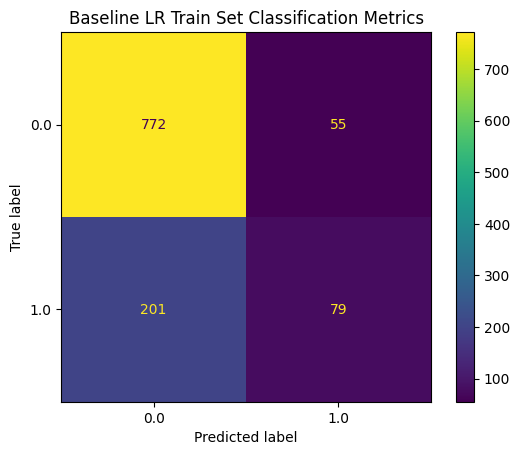

              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       827
         1.0       0.59      0.28      0.38       280

    accuracy                           0.77      1107
   macro avg       0.69      0.61      0.62      1107
weighted avg       0.74      0.77      0.74      1107



In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Baseline LR Train Set Classification Metrics')
plt.show()
print(classification_report(y_test, y_pred))

Dataset is imbalanced, need to adjust.
Should also focus on Recall score since this is a medical issue (better to have False Positive than True Negative!)

In [15]:
y = pivoted_df['Surgery']
X = pivoted_df.drop('Surgery', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Set up pipeline
weight_logreg_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# Define the parameter grid to search over, including class weights
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}],
    'logreg__max_iter': [5000],
    'logreg__tol': [0.01]
}

# Create a scoring function that focuses on recall for the positive class
recall_scorer = make_scorer(recall_score, pos_label=1)

# Initialize GridSearch with pipeline, param grid, and recall
grid_search = GridSearchCV(weight_logreg_pipeline, param_grid, cv=5, scoring=recall_scorer, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found and the best recall score
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation recall score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test set recall score: {:.2f}".format(recall_score(y_test, y_pred)))

Best parameters:  {'logreg__C': 0.01, 'logreg__class_weight': {0: 1, 1: 5}, 'logreg__max_iter': 5000, 'logreg__penalty': 'l1', 'logreg__tol': 0.01}
Best cross-validation recall score: 0.87
Test set recall score: 0.85


In [18]:
best_model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.01, class_weight={0: 1, 1: 5},
                                    max_iter=5000, penalty='l1',
                                    solver='liblinear', tol=0.01))])

In [19]:
best_model.score(X_test, y_test)

0.5158084914182475

In [20]:
y_pred = best_model.predict(X_test)

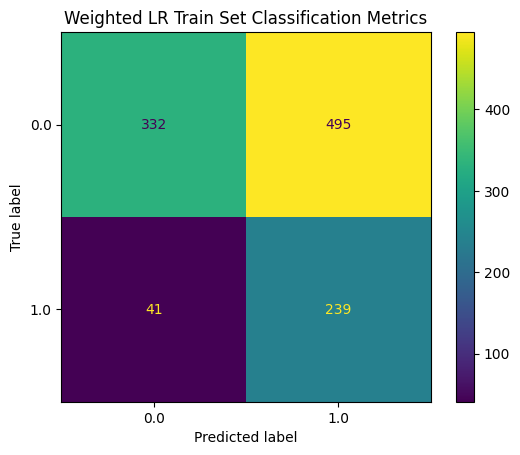

              precision    recall  f1-score   support

         0.0       0.89      0.40      0.55       827
         1.0       0.33      0.85      0.47       280

    accuracy                           0.52      1107
   macro avg       0.61      0.63      0.51      1107
weighted avg       0.75      0.52      0.53      1107



In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Weighted LR Train Set Classification Metrics')
plt.show()
print(classification_report(y_test, y_pred))

Much better model. False Negatives is low, other classes much higher.

In [22]:
coef = best_model['logreg'].coef_

In [23]:
features = pivoted_df.columns

zipped = zip(features, coef[0])
sorted_pairs = sorted(zipped, key=lambda x: x[1], reverse=True)
sorted_pairs

feature_importances = pd.DataFrame(sorted_pairs, columns=['feature', 'importance'])
feature_importances = feature_importances[abs(feature_importances['importance']) > 0.003]

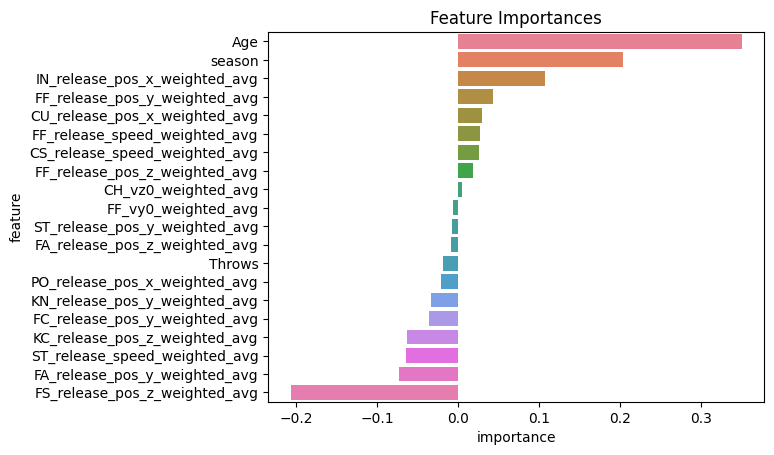

In [24]:
sns.barplot(x='importance', y='feature', data=feature_importances, hue='feature')
plt.title('Feature Importances')
plt.show()

Need to update feature names so they can be understood more easily.

In [25]:
feature_importances

,feature,importance
0,Age,0.350326
1,season,0.204089
2,IN_release_pos_x_weighted_avg,0.106698
3,FF_release_pos_y_weighted_avg,0.042848
4,CU_release_pos_x_weighted_avg,0.028877
5,FF_release_speed_weighted_avg,0.026781
6,CS_release_speed_weighted_avg,0.026057
7,FF_release_pos_z_weighted_avg,0.017854
8,CH_vz0_weighted_avg,0.004592
118,FF_vy0_weighted_avg,-0.005897


In [26]:
# This will rename the index if 'feature' is actually set as the index of the DataFrame
feature_importances = feature_importances.set_index('feature')  # Make sure 'feature' is the index
feature_importances = feature_importances.rename(index={
    'season': 'Season',
    'IN_release_pos_x_weighted_avg': 'Intentional Ball Release Position X-dimension avg.',
    'FF_release_pos_y_weighted_avg': 'Fastball Release Position Y-dimension avg.',
    'CU_release_pos_x_weighted_avg': 'Curveball Release Position X-dimension avg.',
    'FF_release_pos_z_weighted_avg': 'Fastball Release Position Z-dimension avg.',
    'CU_release_pos_z_weighted_avg': 'Curveball Release Position Z-dimension avg.',
    'CS_release_speed_weighted_avg': 'Slow Curve Release Speed avg.',
    'FF_release_speed_weighted_avg': 'Fastball Release Speed avg.',
    'CU_release_speed_weighted_avg': 'Curveball Release Speed avg.',
    'ST_vy0_weighted_avg': 'Sweeper Velocity Y-dimension avg.',
    'CH_vz0_weighted_avg': 'Changeup Velocity Z-dimension avg.',
    'FF_vy0_weighted_avg': 'Fastball Velocity Y-dimension avg.',
    'ST_release_speed_weighted_avg': 'Sweeper Release Speed avg.',
    'CS_vy0_weighted_avg': 'Slow Curve Velocity Y-dimension avg.',
    'PO_release_pos_x_weighted_avg': 'Pick-off Release Position X-dimension avg.',
    'ST_release_pos_z_weighted_avg': 'Sweeper Release Position Z-dimension avg.',
    'ST_release_pos_y_weighted_avg': 'Sweeper Release Position Y-dimension avg.',
    'KN_release_pos_y_weighted_avg': 'Knuckleball Release Position Y-dimension avg.',
    'FC_release_pos_y_weighted_avg': 'Cutter Release Position Y-dimension avg.',
    'KC_release_pos_z_weighted_avg': 'Knucklecurve Release Position Z-dimension avg.',
    'FA_release_pos_y_weighted_avg': '4-seam Fastball Release Position Y-dimension avg.',
    'FS_release_pos_z_weighted_avg': 'Split-finger Release Position Z-dimension avg.'

})

In [27]:
feature_importances

,importance
feature,
Age,0.350326
Season,0.204089
Intentional Ball Release Position X-dimension avg.,0.106698
Fastball Release Position Y-dimension avg.,0.042848
Curveball Release Position X-dimension avg.,0.028877
Fastball Release Speed avg.,0.026781
Slow Curve Release Speed avg.,0.026057
Fastball Release Position Z-dimension avg.,0.017854
Changeup Velocity Z-dimension avg.,0.004592


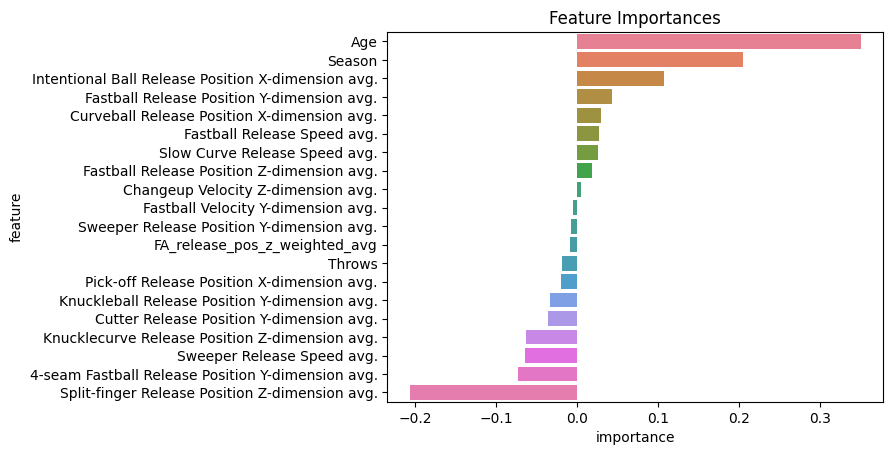

In [28]:
sns.barplot(x='importance', y='feature', data=feature_importances, hue='feature')
plt.title('Feature Importances')
plt.show()

This shows the features that have the most impact in predicting 1.0 surgery (positive and negative)

Decision Tree Classifier, baseline model.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

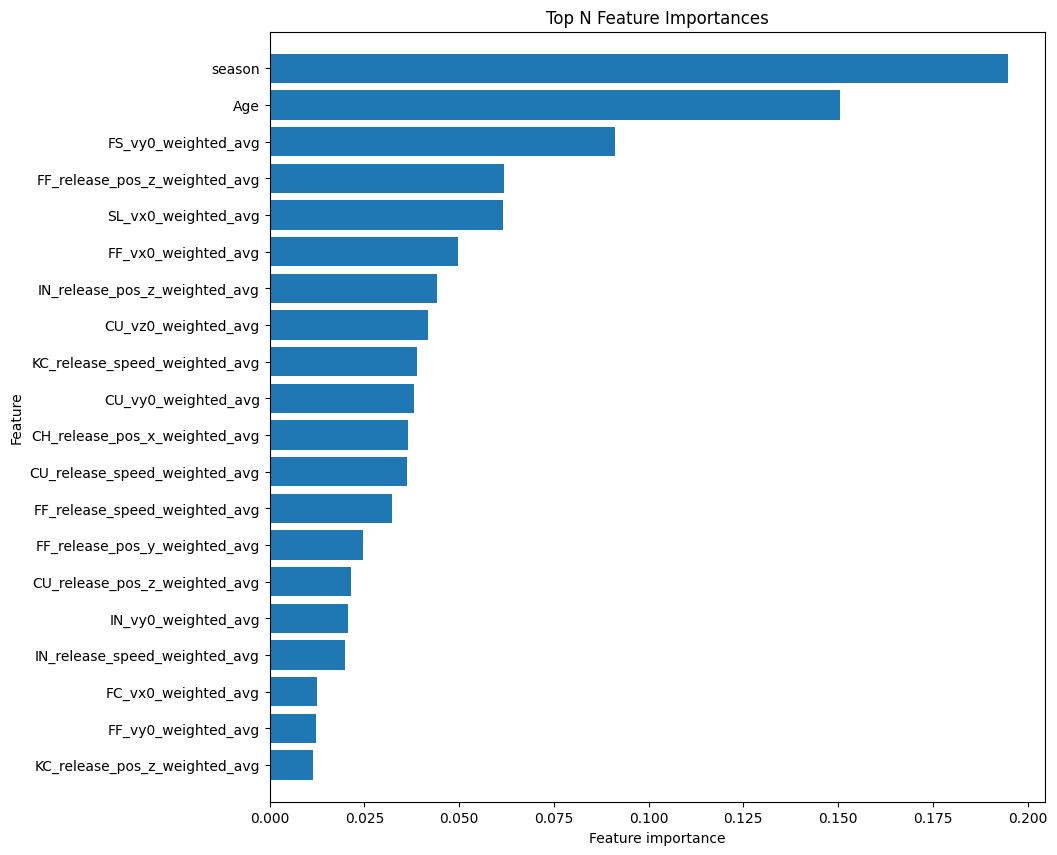

In [31]:
def plot_feature_importances(model, n_top_features=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n_top_features:]
    plt.figure(figsize=(10,10))
    plt.title('Top N Feature Importances')
    plt.barh(range(n_top_features), importances[indices], align='center')
    plt.yticks(range(n_top_features), [X_train.columns[i] for i in indices])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_top_features)

plot_feature_importances(tree_clf, n_top_features=20)
plt.show()

In [32]:
pred = tree_clf.predict(X_test)

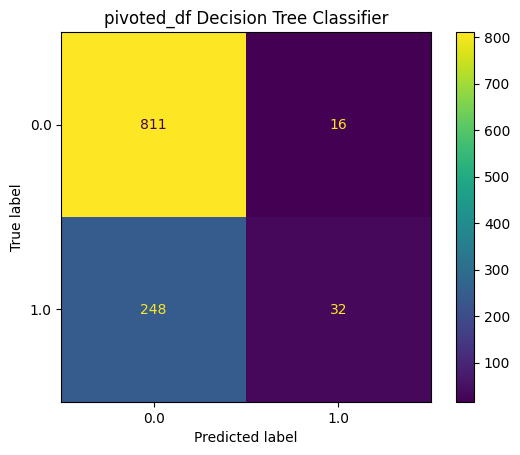

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       827
         1.0       0.67      0.11      0.20       280

    accuracy                           0.76      1107
   macro avg       0.72      0.55      0.53      1107
weighted avg       0.74      0.76      0.69      1107



In [33]:
pred = tree_clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title('pivoted_df Decision Tree Classifier')
plt.show()
print(classification_report(y_test, pred))

Terrible for TP and FP. Need to adjust.
Features are interesting. Mostly fastball, curveball, some slider and split-finger.

In [34]:
y = pivoted_df['Surgery']
X = pivoted_df.drop('Surgery', axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]
}

tree_clf = DecisionTreeClassifier()
scorer = make_scorer(recall_score)
grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
print("Test recall score:", recall_score(y_test, y_pred))

Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best score: 0.6540600393700788
Test recall score: 0.7607142857142857


In [37]:
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=10)

In [38]:
pred = best_tree.predict(X_test)

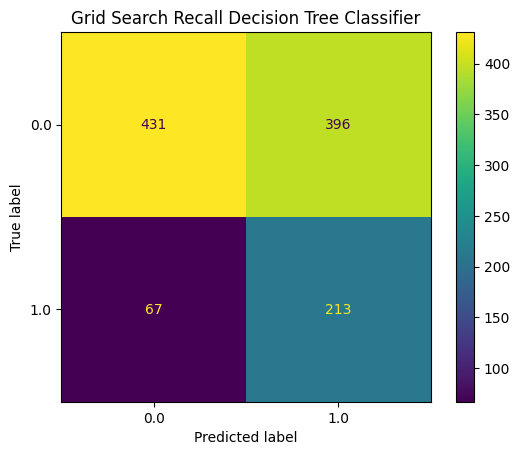

              precision    recall  f1-score   support

         0.0       0.87      0.52      0.65       827
         1.0       0.35      0.76      0.48       280

    accuracy                           0.58      1107
   macro avg       0.61      0.64      0.56      1107
weighted avg       0.74      0.58      0.61      1107



In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.title('Grid Search Recall Decision Tree Classifier')
plt.show()
print(classification_report(y_test, pred))

The Logistic Regression model with adjusted class weights performed the best.
